In [1]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union, unary_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
raster_path = "T36UXV_20200406T083559_TCI_10m.jp2"
with rasterio.open(raster_path, "r+", driver="JP2OpenJPEG") as src:
    raster_img = src.read()
    raster_meta = src.meta
    print(src.bounds)
print(raster_img.shape)
print(type(raster_img))

BoundingBox(left=600000.0, bottom=5390220.0, right=709800.0, top=5500020.0)
(3, 10980, 10980)
<class 'numpy.ndarray'>


In [3]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 5500020.0)}

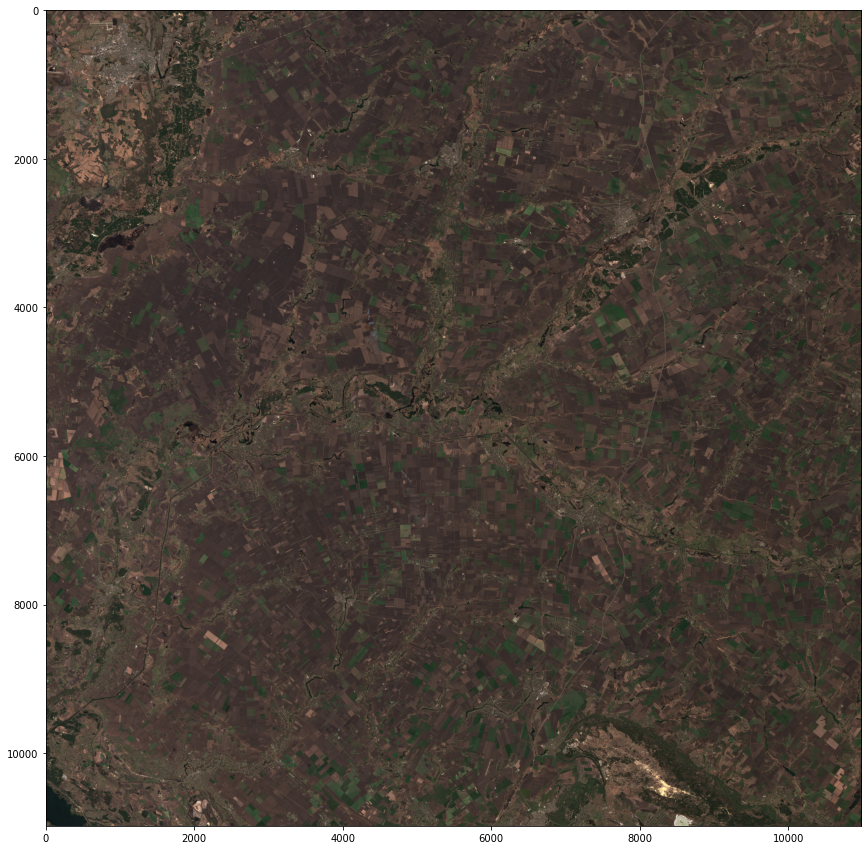

In [4]:
raster_img = reshape_as_image(raster_img)
plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [5]:
train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [6]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

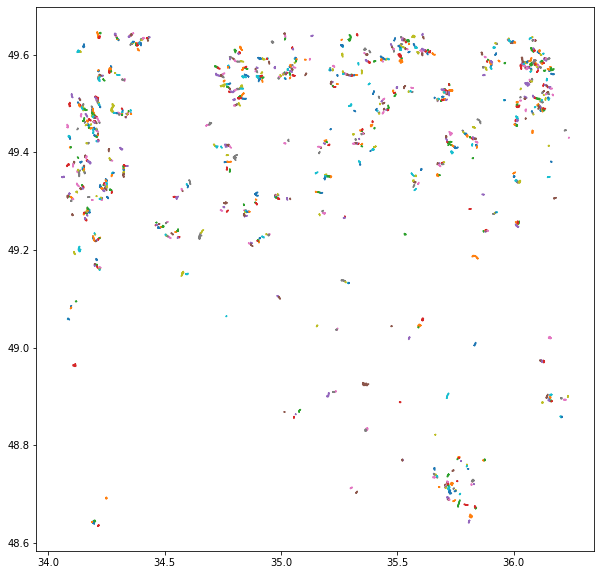

In [7]:
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt

sf = shp.Reader("masks/Masks_T36UXV_20190427.shp")

plt.figure(figsize = (10,10))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.show()

In [8]:
src = rasterio.open(raster_path, 'r')
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
    except:
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))

Rasterio failed to mask 936 files


In [9]:
train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")

# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]
# assigning crs
train_df.crs = {'init' :'epsg:4324'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})
print(train_df.crs)

+init=epsg:32636 +type=crs


/home/jr/anaconda3/envs/ml/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/jr/anaconda3/envs/ml/lib/python3.8/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [10]:
train_df['id'] = train_df.index
train_df.head(5)

,id,Data,Code,Descriptio,Comments,Image,geometry
0,0,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((689977.436 5497806.680, 690053.741 5..."
1,1,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((691534.908 5497817.474, 691661.287 5..."
2,2,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((690033.666 5498401.306, 689984.395 5..."
3,3,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((689315.416 5498464.022, 689335.534 5..."
4,4,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((688168.998 5498617.338, 688265.794 5..."


In [11]:
src = rasterio.open(raster_path, 'r', driver="JP2OpenJPEG")
outfolder = "article"
os.makedirs(outfolder, exist_ok=True)
failed = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_image = reshape_as_image(masked_image)
        img_path = os.path.join(outfolder, str(row['id']) + '.png')
        img_image = cv2.cvtColor(img_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(img_path, img_image)
    except Exception as e:
        # print(e)
        # print(src.bounds)
        # print(row['geometry'])
        failed.append(num)
print("Rasterio failed to mask {} files".format(len(failed)))
print("Rasterio succeded to mask {} files".format(train_df.shape[0]-len(failed)))

Rasterio failed to mask 435 files
Rasterio succeded to mask 500 files


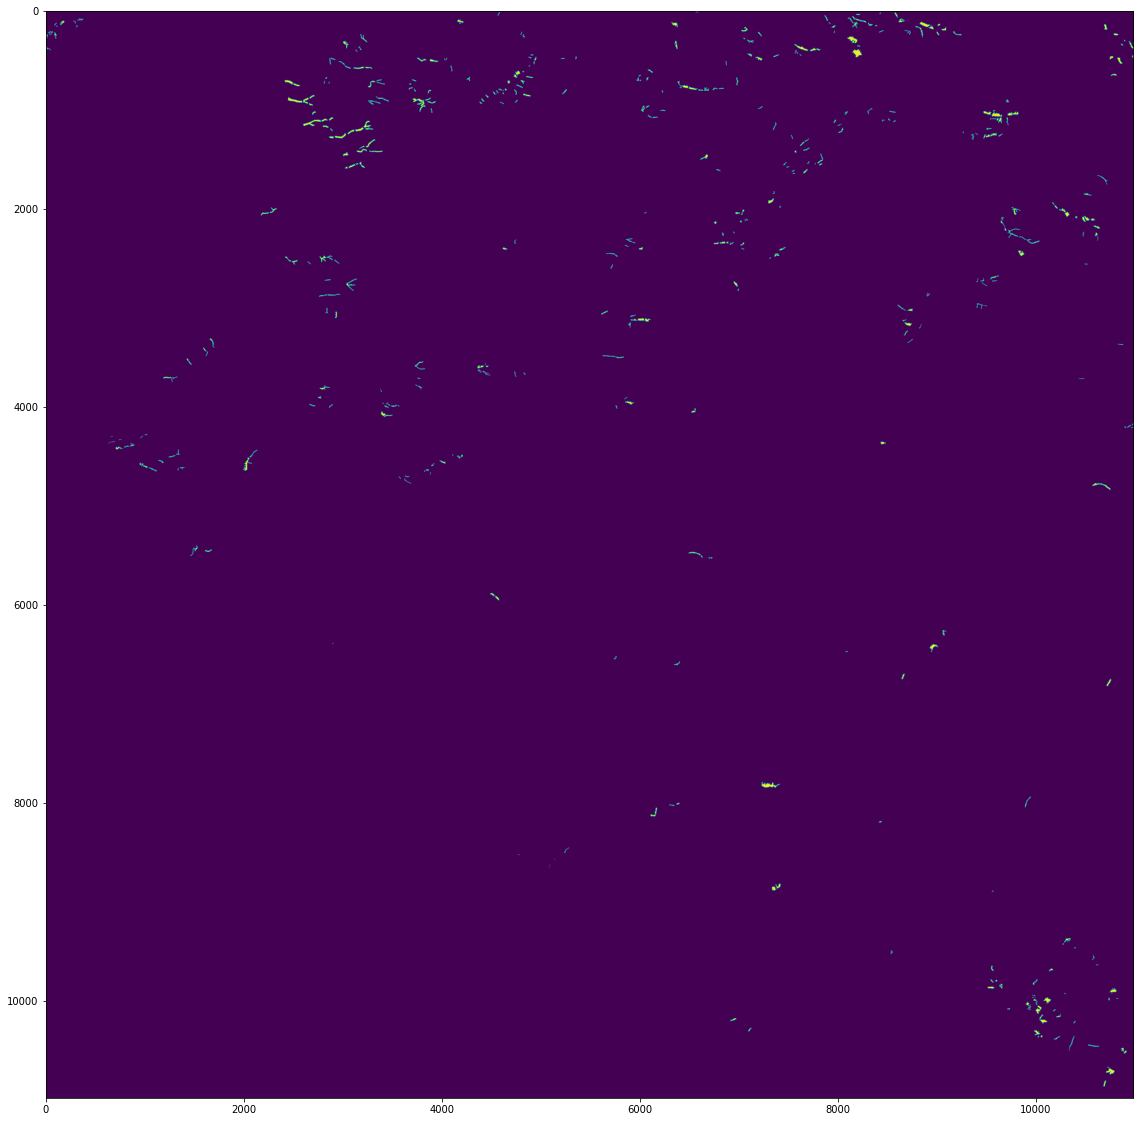

In [12]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = unary_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for eroding/not_eroding segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(20,20))
plt.imshow(mask)

In [14]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open("mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)